<a href="https://colab.research.google.com/github/Nachi2006/MLREPO/blob/main/AirQuality_AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-9645600477c3>:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2022-01-01', periods=8760, freq='H')  # Hourly data for a year


Dataset loaded with shape: (8760, 19)

=== Initial Data Exploration ===

First few rows:
            timestamp  PM2.5_Sensor_A  PM2.5_Sensor_B  PM2.5_Sensor_C  \
0 2022-01-01 00:00:00       69.934283       56.039456       54.278662   
1 2022-01-01 01:00:00       59.822904       68.321887       48.192320   
2 2022-01-01 02:00:00       77.953771       39.509796       65.834306   
3 2022-01-01 03:00:00       97.531665      106.874023       54.812984   
4 2022-01-01 04:00:00     -200.000000       51.624134       67.161982   

   PM10_Sensor_A  PM10_Sensor_B  PM10_Sensor_C  NO2_Sensor_A  NO2_Sensor_B  \
0      71.453311      54.534224      62.280595     43.800850     61.654877   
1      73.679241      64.005298      83.100492     89.848751     70.268037   
2      79.159008      26.487740      64.868690     55.555509     95.829486   
3      99.441182      55.879607      57.625647     54.999691     68.680310   
4      72.645315      86.434111      63.005899    436.620769     99.203489   

   

<ipython-input-2-9645600477c3>:271: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg = df.groupby('season')[numerical_cols].mean()


Seasonal patterns saved as 'seasonal_patterns.png'

=== Final Dataset Preparation ===
Processed dataset saved as 'processed_air_quality_data.csv'

=== Summary of Preprocessing Steps ===
1. Data Loading and Initial Exploration
2. Missing Value Identification and Imputation using KNN
3. Feature Scaling using Robust Scaler
4. Time-Based Feature Engineering
5. Outlier Detection using IQR and Handling using Winsorization
6. Exploratory Data Analysis with Visualizations
7. Final Dataset Preparation and Export

The dataset is now ready for further analysis or predictive modeling!

=== Machine Learning with AdaBoost ===
Preparing data to predict PM2.5_Sensor_A levels 24 hours in advance...
Dataset shape for machine learning: (8712, 54)
Number of features: 54
Splitting data into training and testing sets using time series split...
Training set size: 1452 samples
Testing set size: 1452 samples

Training AdaBoost Regressor model...

Evaluating AdaBoost model performance...
Mean Squared Error (MSE

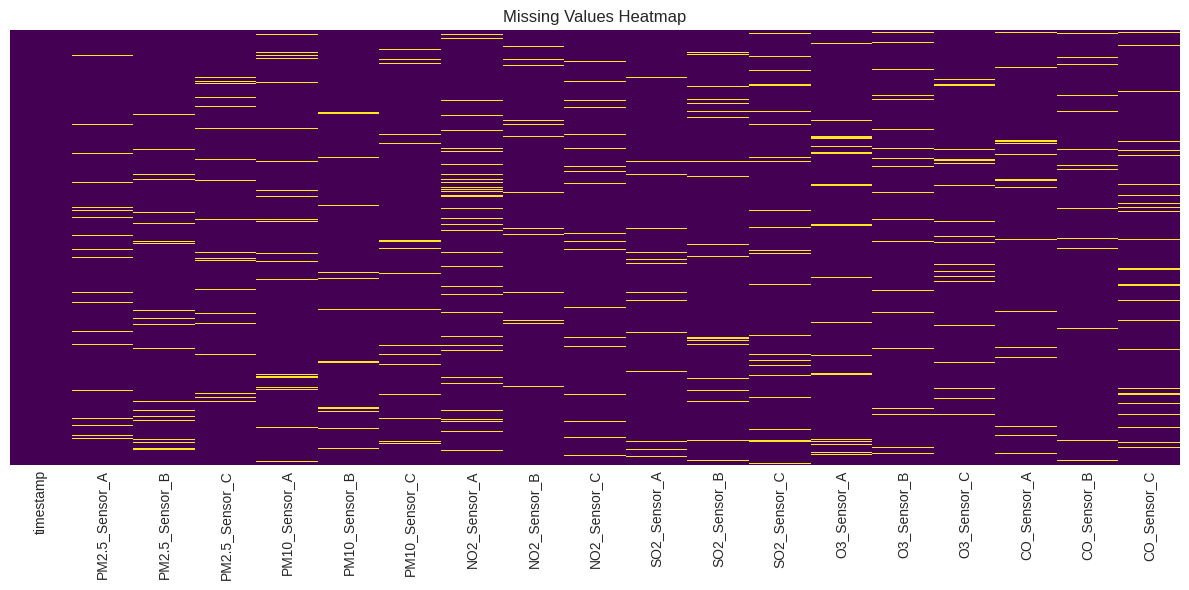

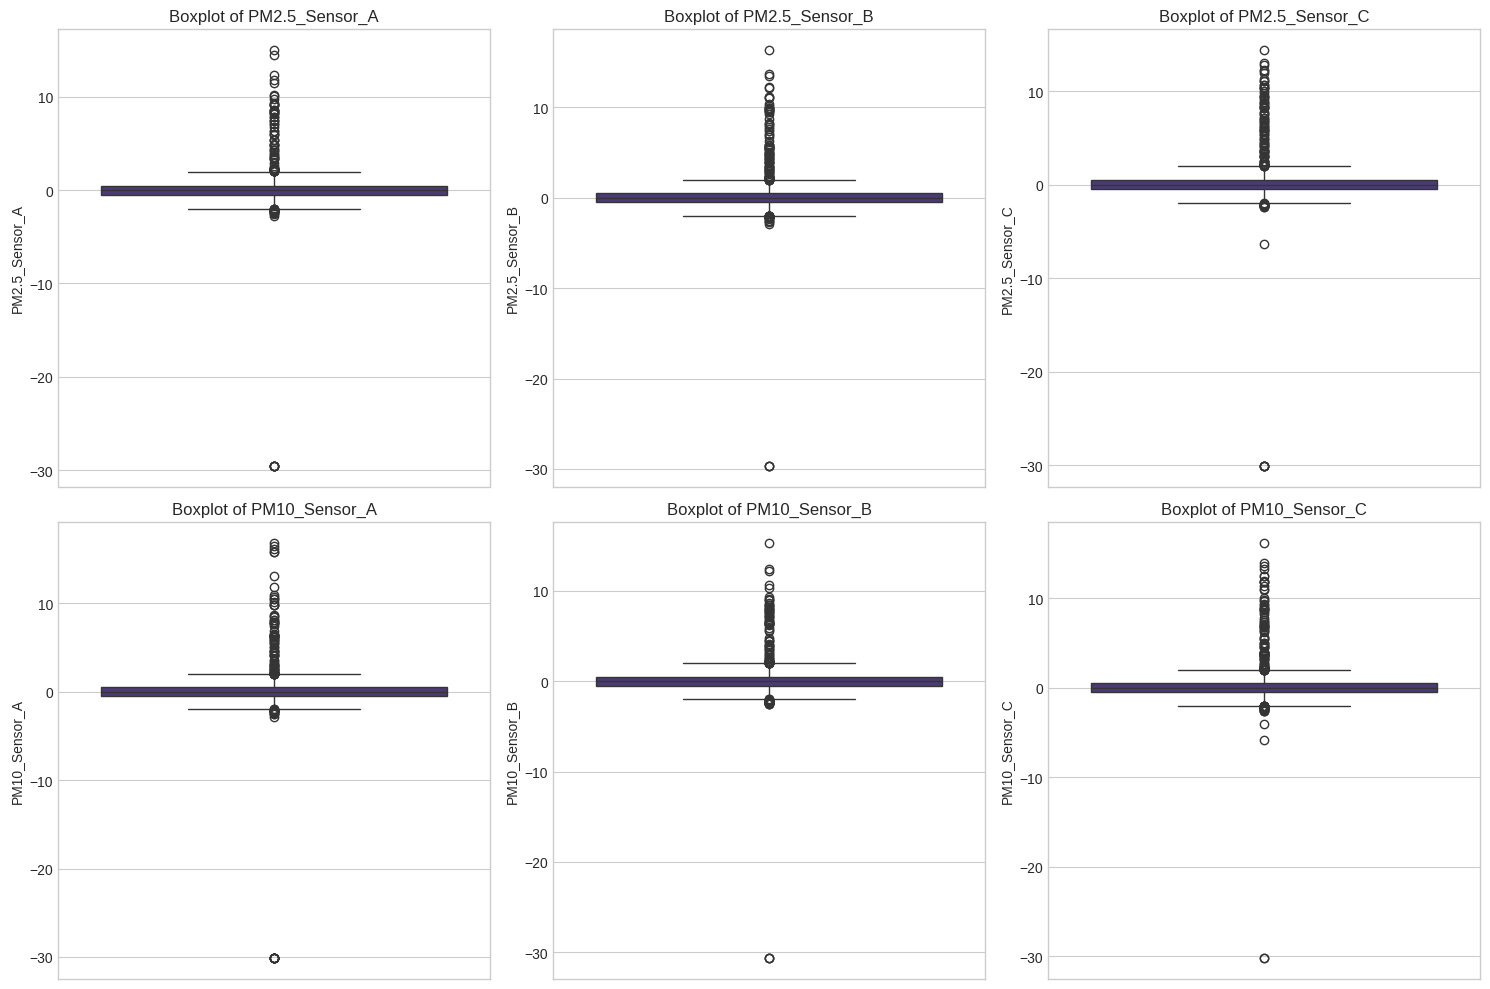

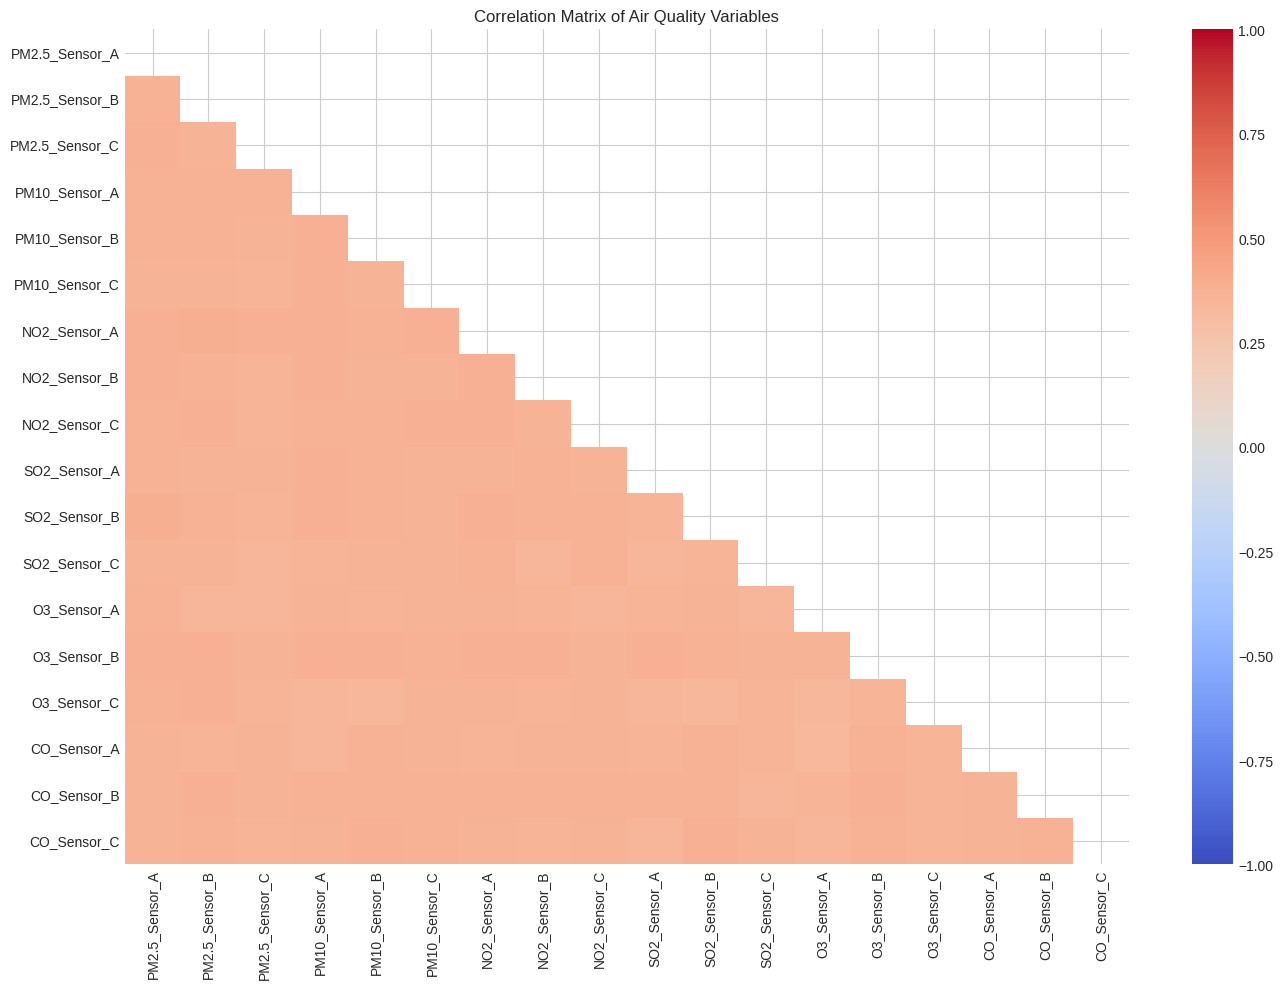

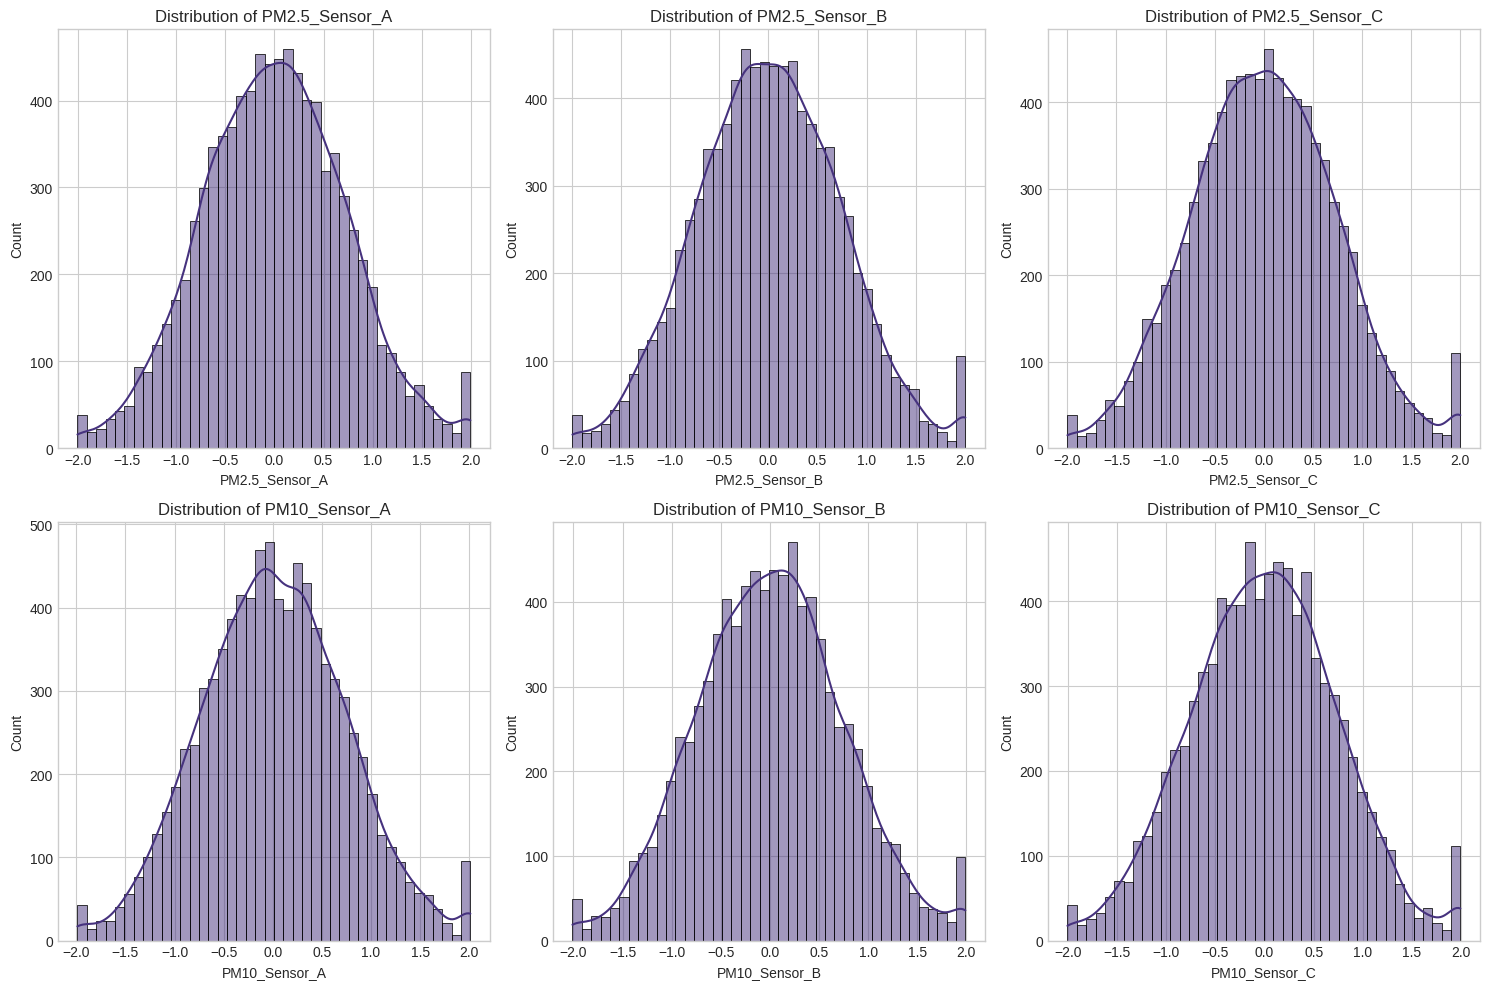

<Figure size 1400x600 with 0 Axes>

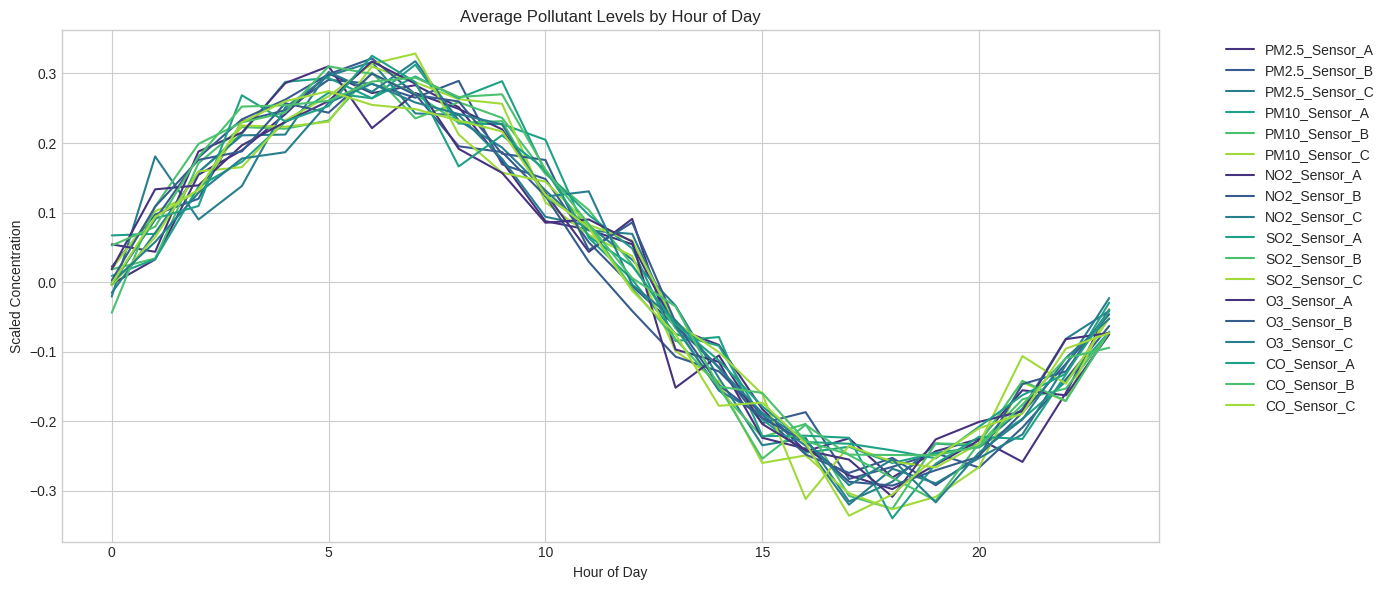

<Figure size 1400x600 with 0 Axes>

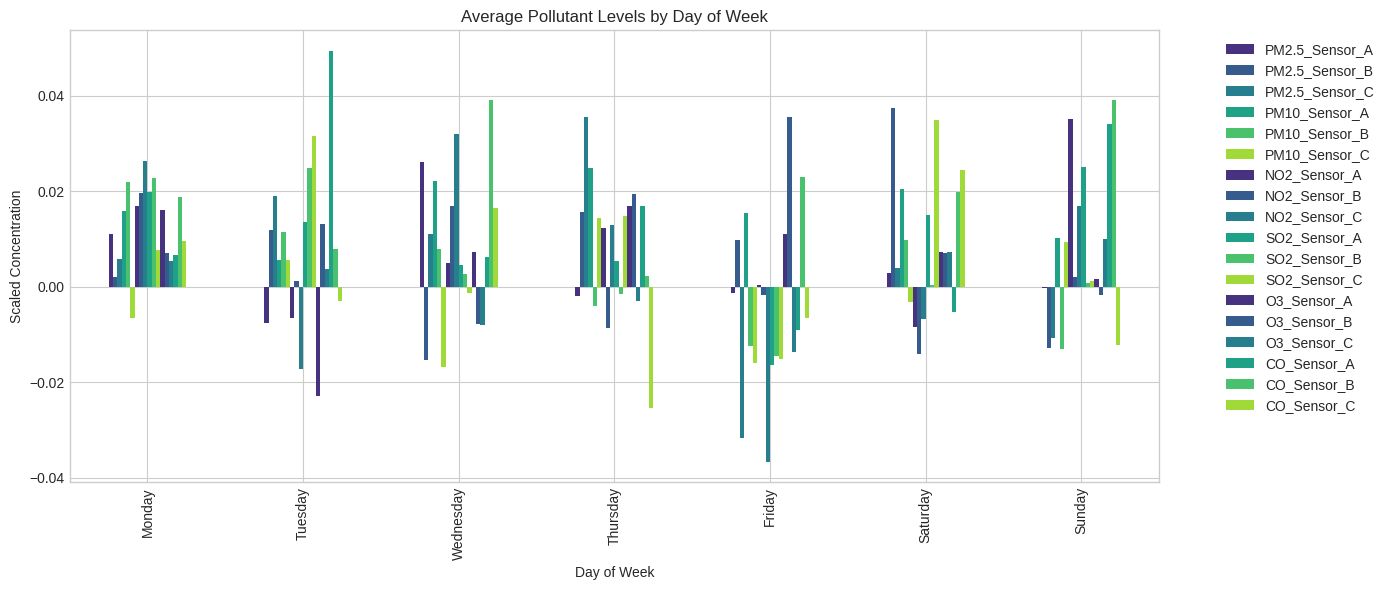

<Figure size 1400x600 with 0 Axes>

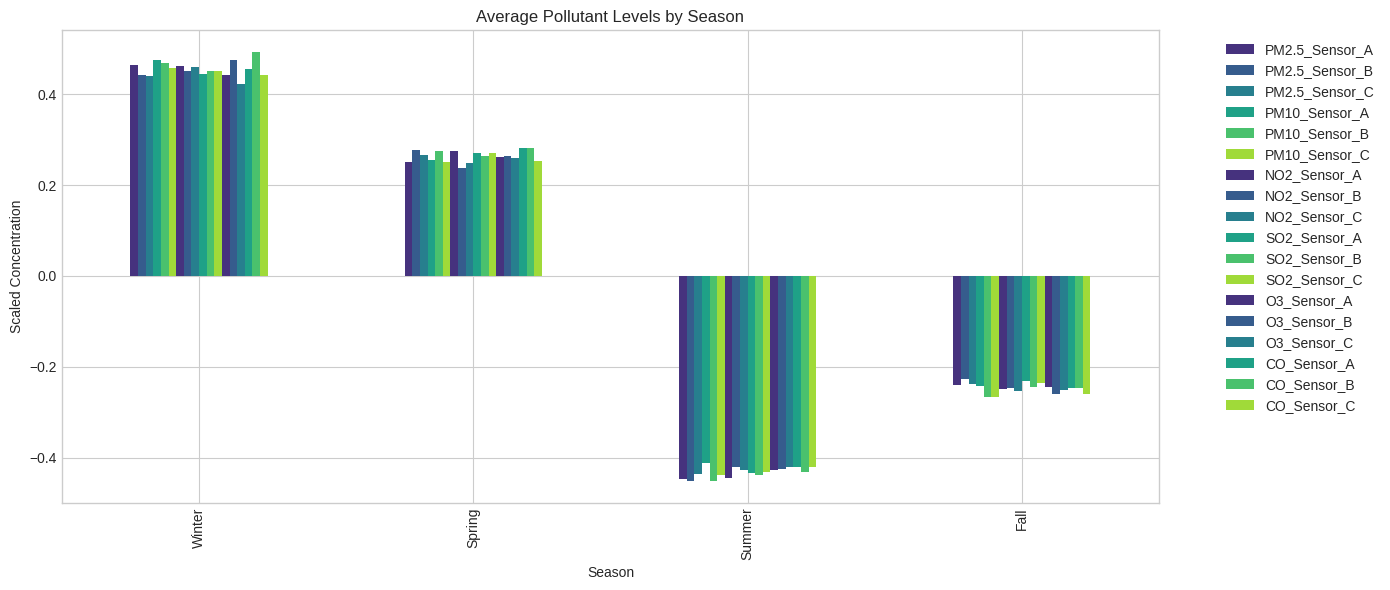

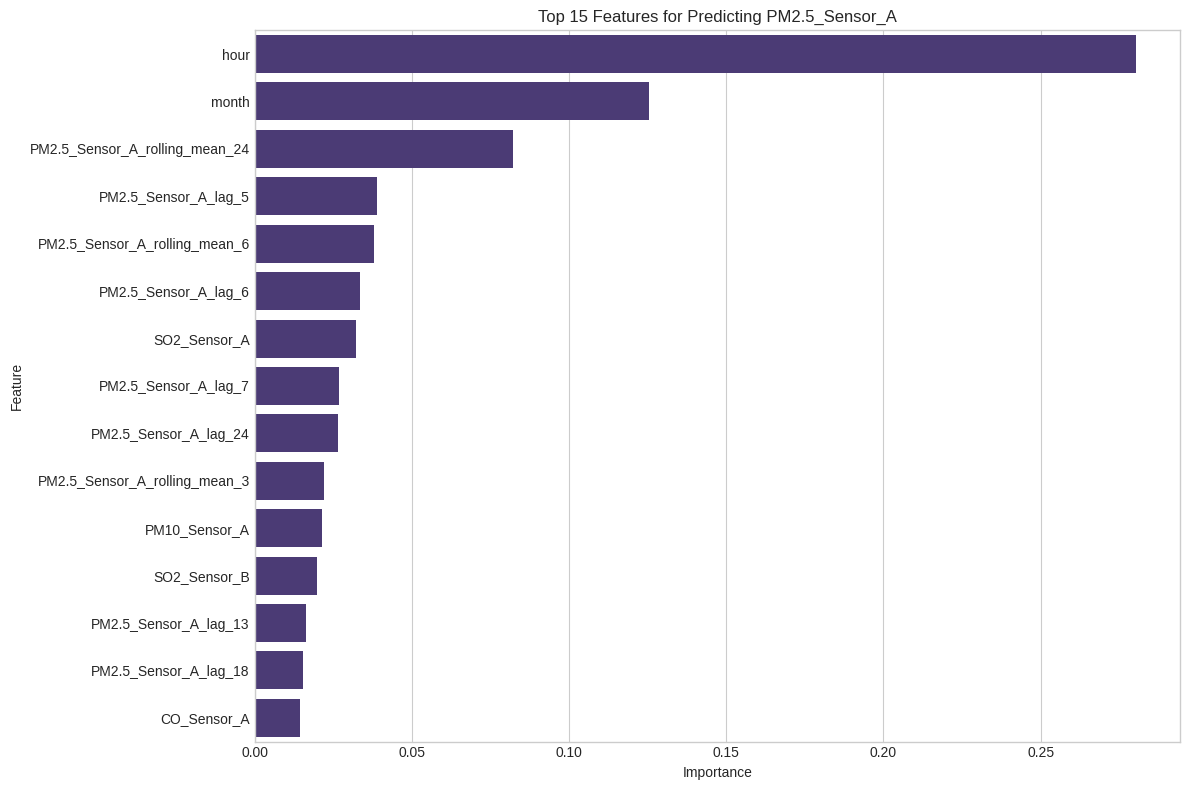

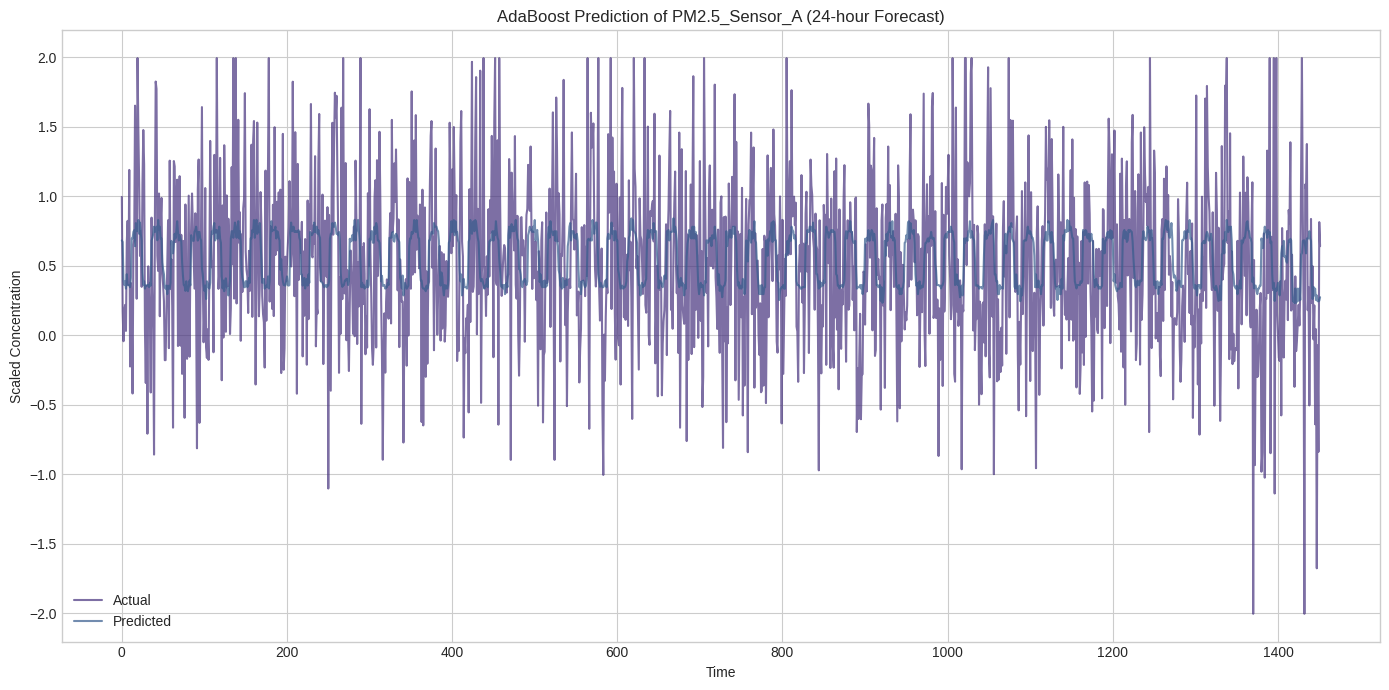

In [2]:
# Air Quality Dataset Preprocessing
# ================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


np.random.seed(42)
dates = pd.date_range(start='2022-01-01', periods=8760, freq='H')  # Hourly data for a year
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
sensors = ['Sensor_A', 'Sensor_B', 'Sensor_C']

# Create sample data
data = {}
data['timestamp'] = dates
for pollutant in pollutants:
    for sensor in sensors:
        col_name = f"{pollutant}_{sensor}"
        # Generate random values with some seasonal patterns
        base = np.random.normal(50, 20, len(dates))
        # Add seasonal component (higher in winter months)
        seasonal = 20 * np.sin(np.pi * dates.month / 6)
        # Add daily pattern (higher during rush hours)
        daily = 10 * np.sin(np.pi * dates.hour / 12)
        values = base + seasonal.values + daily.values

        # Introduce some missing values (-200)
        mask = np.random.random(len(dates)) < 0.05  # 5% missing
        values[mask] = -200

        # Introduce some outliers
        outlier_mask = np.random.random(len(dates)) < 0.01  # 1% outliers
        values[outlier_mask] = values[outlier_mask] * 5

        data[col_name] = values

df = pd.DataFrame(data)
print(f"Dataset loaded with shape: {df.shape}")

# 2. Initial Data Exploration
# ===========================
print("\n=== Initial Data Exploration ===")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# 3. Handling Missing Values
# ==========================
print("\n=== Handling Missing Values ===")

# Identify missing values (tagged as -200)
print("\nCounting values tagged as -200 (missing):")
missing_counts = {}
for column in df.columns:
    if column != 'timestamp':  # Skip timestamp column
        count = (df[column] == -200).sum()
        if count > 0:
            missing_counts[column] = count
            print(f"{column}: {count} missing values")

# Replace -200 with NaN for proper handling
for column in df.columns:
    if column != 'timestamp':
        df[column] = df[column].replace(-200, np.nan)

print("\nMissing value percentage by column:")
missing_percentage = df.isna().mean() * 100
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.savefig('missing_values_heatmap.png')
print("Missing values heatmap saved as 'missing_values_heatmap.png'")

# Imputation strategy
print("\nApplying KNN imputation for missing values...")
# We're using KNN imputation because:
# 1. It considers the relationships between features
# 2. It works well for time series data where values are related to nearby timestamps
# 3. It preserves the distribution better than simple mean/median imputation

# Extract numerical columns for imputation
numerical_cols = df.columns.drop('timestamp')
imputer = KNNImputer(n_neighbors=5)
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

print("Missing values after imputation:")
print(df.isna().sum().sum())

# 4. Feature Scaling
# ==================
print("\n=== Feature Scaling ===")
print("Applying Robust Scaling to numerical features...")

# We choose Robust Scaler because:
# 1. It's resistant to outliers (uses median and quartiles)
# 2. Air quality data often contains outliers due to pollution events
# 3. It preserves the relative relationships between normal and extreme values

scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Data after scaling:")
print(df[numerical_cols].describe())

# 5. Time-Based Feature Engineering
# =================================
print("\n=== Time-Based Feature Engineering ===")

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['season'] = pd.cut(
    df['timestamp'].dt.month,
    bins=[0, 3, 6, 9, 12],
    labels=['Winter', 'Spring', 'Summer', 'Fall'],
    include_lowest=True
)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_holiday'] = 0  # Placeholder - in real application, you'd use a holiday calendar

print("Time-based features added:")
print(df[['hour', 'day_of_week', 'day_name', 'month', 'month_name', 'season', 'is_weekend']].head())

print("\nThese time-based features can improve predictive modeling by:")
print("1. Capturing cyclical patterns (daily, weekly, seasonal variations in pollution)")
print("2. Accounting for human activity patterns (weekday vs weekend, rush hours)")
print("3. Incorporating seasonal weather effects on pollutant dispersion")
print("4. Enabling the model to learn time-specific relationships between variables")

# 6. Outlier Detection & Handling
# ===============================
print("\n=== Outlier Detection & Handling ===")

# We'll use the IQR method for outlier detection
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Detect outliers in each pollutant column
print("Detecting outliers using IQR method:")
outlier_summary = {}

for column in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(df, column)
    pct_outliers = len(outliers) / len(df) * 100
    outlier_summary[column] = {
        'count': len(outliers),
        'percentage': pct_outliers,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"{column}: {len(outliers)} outliers ({pct_outliers:.2f}%)")

# Visualize outliers for a few selected columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(list(numerical_cols)[:min(6, len(numerical_cols))]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.savefig('outliers_boxplot.png')
print("Outlier boxplots saved as 'outliers_boxplot.png'")

# Handle outliers using capping (Winsorization)
print("\nHandling outliers using Winsorization (capping):")
for column in numerical_cols:
    lower = outlier_summary[column]['lower_bound']
    upper = outlier_summary[column]['upper_bound']
    # Count values outside bounds before capping
    outliers_before = ((df[column] < lower) | (df[column] > upper)).sum()
    # Apply capping
    df[column] = df[column].clip(lower=lower, upper=upper)
    # Count values outside bounds after capping
    outliers_after = ((df[column] < lower) | (df[column] > upper)).sum()
    print(f"{column}: {outliers_before - outliers_after} outliers capped")

print("\nWe chose Winsorization (capping) because:")
print("1. It preserves the data points while limiting their extreme values")
print("2. It's suitable for environmental data where extreme events are real but may skew analysis")
print("3. It maintains the overall data distribution better than removal")
print("4. It's more robust for time-series data where removing points creates gaps")

# 7. Exploratory Data Analysis (EDA)
# ==================================
print("\n=== Exploratory Data Analysis ===")

# Summary statistics for key features
print("\nSummary statistics after preprocessing:")
print(df[numerical_cols].describe())

# Correlation analysis
plt.figure(figsize=(14, 10))
correlation = df[numerical_cols].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=False, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Air Quality Variables')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
print("Correlation matrix saved as 'correlation_matrix.png'")

# Distribution of pollutants
plt.figure(figsize=(15, 10))
for i, column in enumerate(list(numerical_cols)[:min(6, len(numerical_cols))]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig('pollutant_distributions.png')
print("Pollutant distributions saved as 'pollutant_distributions.png'")

# Time-based patterns
# Daily patterns
plt.figure(figsize=(14, 6))
hourly_avg = df.groupby('hour')[numerical_cols].mean()
hourly_avg.plot(figsize=(14, 6))
plt.title('Average Pollutant Levels by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Scaled Concentration')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('hourly_patterns.png')
print("Hourly patterns saved as 'hourly_patterns.png'")

# Weekly patterns
plt.figure(figsize=(14, 6))
daily_avg = df.groupby('day_name')[numerical_cols].mean()
# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex(day_order)
daily_avg.plot(kind='bar', figsize=(14, 6))
plt.title('Average Pollutant Levels by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Scaled Concentration')
plt.grid(True, axis='y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('weekly_patterns.png')
print("Weekly patterns saved as 'weekly_patterns.png'")

# Seasonal patterns
plt.figure(figsize=(14, 6))
seasonal_avg = df.groupby('season')[numerical_cols].mean()
seasonal_avg.plot(kind='bar', figsize=(14, 6))
plt.title('Average Pollutant Levels by Season')
plt.xlabel('Season')
plt.ylabel('Scaled Concentration')
plt.grid(True, axis='y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('seasonal_patterns.png')
print("Seasonal patterns saved as 'seasonal_patterns.png'")

# 8. Final Dataset Preparation
# ===========================
print("\n=== Final Dataset Preparation ===")

# Create a copy of the processed dataset
processed_df = df.copy()

# Save the processed dataset
processed_df.to_csv('processed_air_quality_data.csv', index=False)
print("Processed dataset saved as 'processed_air_quality_data.csv'")

# 9. Summary of Preprocessing Steps
# ================================
print("\n=== Summary of Preprocessing Steps ===")
print("1. Data Loading and Initial Exploration")
print("2. Missing Value Identification and Imputation using KNN")
print("3. Feature Scaling using Robust Scaler")
print("4. Time-Based Feature Engineering")
print("5. Outlier Detection using IQR and Handling using Winsorization")
print("6. Exploratory Data Analysis with Visualizations")
print("7. Final Dataset Preparation and Export")

print("\nThe dataset is now ready for further analysis or predictive modeling!")

print("\n=== Machine Learning with AdaBoost ===")

# Import necessary libraries for machine learning
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Define a function to prepare data for prediction
def prepare_data_for_prediction(df, target_pollutant, forecast_horizon=24):
    """
    Prepare data for time series forecasting.

    Parameters:
    -----------
    df : pandas DataFrame
        The processed dataset
    target_pollutant : str
        The pollutant to predict
    forecast_horizon : int
        Number of hours ahead to predict

    Returns:
    --------
    X : feature matrix
    y : target values
    feature_names : list of feature names
    """
    # Create lag features (previous values of the target)
    for lag in range(1, 25):  # Use up to 24 hours of history
        df[f'{target_pollutant}_lag_{lag}'] = df[target_pollutant].shift(lag)

    # Create rolling window features
    for window in [3, 6, 12, 24]:
        df[f'{target_pollutant}_rolling_mean_{window}'] = df[target_pollutant].rolling(window=window).mean()
        df[f'{target_pollutant}_rolling_std_{window}'] = df[target_pollutant].rolling(window=window).std()

    # Drop rows with NaN values (due to lag/rolling features)
    df_ml = df.dropna()

    # Create target variable (future pollution level)
    y = df_ml[target_pollutant].shift(-forecast_horizon)

    # Drop rows with NaN in target (due to future shift)
    df_ml = df_ml[:-forecast_horizon]
    y = y[:-forecast_horizon]

    # Select features for the model
    # Exclude the original pollutant columns and timestamp
    feature_cols = [col for col in df_ml.columns
                   if col != target_pollutant
                   and col != 'timestamp'
                   and not col.startswith('day_name')
                   and not col.startswith('month_name')
                   and not col.startswith('season')]

    # Encode categorical features if any remain
    categorical_cols = [col for col in feature_cols if df_ml[col].dtype == 'object']
    for col in categorical_cols:
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col])

    X = df_ml[feature_cols]

    return X, y, feature_cols

# Choose a target pollutant to predict
target_pollutant = 'PM2.5_Sensor_A'  # You can change this to any pollutant column

print(f"Preparing data to predict {target_pollutant} levels 24 hours in advance...")
X, y, feature_names = prepare_data_for_prediction(processed_df, target_pollutant)

print(f"Dataset shape for machine learning: {X.shape}")
print(f"Number of features: {len(feature_names)}")

# Split the data into training and testing sets
# Using time series split to respect the temporal nature of the data
print("Splitting data into training and testing sets using time series split...")
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break  # Just use the last split

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Train AdaBoost model
print("\nTraining AdaBoost Regressor model...")
# Using Decision Tree as the base estimator
base_estimator = DecisionTreeRegressor(max_depth=4)
adaboost_model = AdaBoostRegressor(
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)

# Fit the model
adaboost_model.fit(X_train, y_train)

# Evaluate the model
print("\nEvaluating AdaBoost model performance...")
y_pred = adaboost_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Cross-validation
print("\nPerforming cross-validation...")
cv_scores = cross_val_score(adaboost_model, X, y, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"Cross-validation RMSE scores: {-cv_scores}")
print(f"Average CV RMSE: {-cv_scores.mean():.4f}")

# Feature importance
print("\nFeature importance:")
feature_importances = adaboost_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(feature_importance_df.head(10))  # Top 10 features

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title(f'Top 15 Features for Predicting {target_pollutant}')
plt.tight_layout()
plt.savefig('adaboost_feature_importance.png')
print("Feature importance plot saved as 'adaboost_feature_importance.png'")

# Visualize predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title(f'AdaBoost Prediction of {target_pollutant} (24-hour Forecast)')
plt.xlabel('Time')
plt.ylabel('Scaled Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('adaboost_predictions.png')
print("Predictions plot saved as 'adaboost_predictions.png'")

# Save the model
from joblib import dump
dump(adaboost_model, 'adaboost_air_quality_model.joblib')
print("Model saved as 'adaboost_air_quality_model.joblib'")

print("\n=== AdaBoost Model Summary ===")
print(f"Target: Predicting {target_pollutant} levels 24 hours in advance")
print(f"Model: AdaBoost Regressor with Decision Tree base estimator")
print(f"Number of estimators: {adaboost_model.n_estimators}")
print(f"Learning rate: {adaboost_model.learning_rate}")
print(f"Performance (RMSE): {rmse:.4f}")
print(f"Top 3 important features: {', '.join(feature_importance_df['Feature'].head(3).tolist())}")
print("\nThe model can be used for forecasting future air quality levels based on current conditions.")